# Trabajo final ADS: Fases sueño

**Alumnos:** Amparo Gálvez Vilar, Lidia Moreno Marín y Alfredo Quiles Sabat

## Carga de librerías

In [42]:
!pip install mne
!pip install yasa
!pip install antropy

In [43]:
import numpy as np
import mne
import yasa
import pandas as pd
import os
import glob
import joblib
import logging
import seaborn
import shap
import antropy as ant
import scipy.signal as sp_sig
import scipy.stats as sp_stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize, StandardScaler, robust_scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from mne.filter import filter_data
from yasa import sliding_window, bandpower_from_psd_ndarray
from xgboost import XGBClassifier, plot_importance

---

## Información importante

http://dataset.isr.uc.pt/ISRUC_Sleep/Content.pdf

Pacientes Data of Subgroup_3. Cada comprimido tiene:
* un fichero .rec que es un .edf (RENOMBRARLO)
* dos ficheros .txt que son las marcas de los especialistas
* dos fichero .xlsx que contienen la misma información (Stage) y más (muy útil si se desea profundizar en porqué se cometen los errores, para descartar épocas de dudosa calidad, etc.).

https://sleeptight.isr.uc.pt/?page_id=48

El PSG está compuesto por las señales de los siguientes canales:

-   EEG (F3, C3, O1, F4, C4 y O2);
-   EOG, derecho e izquierdo (ROC y LOC);
-   electrocardiograma (ECG);
-   tipos de EMG (un m. submentalis -- EMG de la barbilla (X1) -- y dos m. tibialis -- EMG de las piernas);
-   Las referencias se colocaron en los lóbulos de las orejas izquierda y derecha (A1, A2).

---

## Canales del polisomnograma

### Carga de datos de los 10 pacientes

Los datos se cargaron utilizando la biblioteca MNE a partir de 10 archivos en formato EDF que corresponden a registros polisomnográficos de pacientes sanos. La estrategia de carga asegura la correcta manipulación de los datos gracias a las herramientas de esta biblioteca.

In [44]:
path1 = '/content/drive/MyDrive/datos/1/1.edf'
path2 = '/content/drive/MyDrive/datos/2/2.edf'
path3 = '/content/drive/MyDrive/datos/3/3.edf'
path4 = '/content/drive/MyDrive/datos/4/4.edf'
path5 = '/content/drive/MyDrive/datos/5/5.edf'
path6 = '/content/drive/MyDrive/datos/6/6.edf'
path7 = '/content/drive/MyDrive/datos/7/7.edf'
path8 = '/content/drive/MyDrive/datos/8/8.edf'
path9 = '/content/drive/MyDrive/datos/9/9.edf'
path10 = '/content/drive/MyDrive/datos/10/10.edf'

paths = [path1, path2, path3, path4, path5, path6, path7, path8, path9, path10]
raw_list = []
for path in paths:
    raw = mne.io.read_raw_edf(path, preload=True)
    raw_list.append(raw)

Extracting EDF parameters from /content/drive/MyDrive/datos/1/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Extracting EDF parameters from /content/drive/MyDrive/datos/2/2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5645999  =      0.000 ... 28229.995 secs...
Extracting EDF parameters from /content/drive/MyDrive/datos/3/3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4943999  =      0.000 ... 24719.995 secs...
Extracting EDF parameters from /content/drive/MyDrive/datos/4/4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4763999  =      0.000 ... 23819.995 secs...
Extracting EDF parameters from /content/drive/MyDrive/datos/5/5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure..

### Comprobación de la forma de los datos

Inspeccionamos las dimensiones de los datos para verificar la consistencia estructural y la duración de las grabaciones.

In [45]:
for i, raw in enumerate(raw_list, start=1):
    print(f'Raw{i}: {raw.get_data().shape}')

Raw1: (19, 5724000)
Raw2: (19, 5646000)
Raw3: (19, 4944000)
Raw4: (19, 4764000)
Raw5: (19, 5664000)
Raw6: (19, 5118000)
Raw7: (19, 4884000)
Raw8: (19, 6000000)
Raw9: (19, 5814000)
Raw10: (19, 4776000)


En primer lugar, está el número de canales (dimensión 1), para todos los pacientes hay 19 canales EEG.

En segundo lugar, está el número de puntos de datos (dimensión 2) que corresponde a la duración de la grabación multiplicada por la frecuencia de muestreo.

Esto confirma que todos los datos tienen 19 canales EEG, pero las duraciones de las grabaciones varían entre pacientes. No todas las grabaciones corresponden exactamente a 8 horas. Las duraciones varían entre pacientes, con valores que oscilan alrededor de las 8 horas.



$Duración(h) = \frac{NumPuntos}{Frecuencia Muestreo}\div 3600 ≈ 8h  $

Ejemplo del análisis de un archivo:

In [46]:
type(raw_list[0])

mne.io.edf.edf.RawEDF

In [47]:
raw_list[0].info

<Info | 8 non-empty values
 bads: []
 ch_names: LOC-A2, ROC-A1, F3-A2, C3-A2, O1-A2, F4-A1, C4-A1, O2-A1, X1, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2009-03-28 23:19:00 UTC
 nchan: 19
 projs: []
 sfreq: 200.0 Hz
 subject_info: <subject_info | his_id: 1>
>

El archivo cargado se representa como un objeto de tipo `RawEDF` de la biblioteca MNE.

El archivo contiene 19 canales de EEG, todos marcados como buenos, lo que indica que no se han detectado canales dañados o con problemas.

La señal fue registrada a una frecuencia de muestreo de 200 Hz, lo que implica que se capturan 200 muestras por segundo para cada canal, asegurando una resolución temporal adecuada para el análisis.

Además, se aplicaron filtros que incluyen un pasaaltos en 0 Hz, lo que significa que no hay un filtro activo para eliminar componentes de baja frecuencia; y un pasabajos en 100 Hz, lo que preserva las frecuencias relevantes para EEG al filtrar las superiores a este valor.

Este paso asegura que los datos son técnicamente correctos para continuar con el preprocesamiento.

### Eliminar canales innecesarios

In [48]:
for i, raw in enumerate(raw_list, start=1):
  raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2',
                     'DC8','ROC-A1', 'F3-A2', 'C3-A2', 'F4-A1','O2-A1', 'X2', 'X3' ])
  print(f'Canales eliminados en raw{i}')

Canales eliminados en raw1
Canales eliminados en raw2
Canales eliminados en raw3
Canales eliminados en raw4
Canales eliminados en raw5
Canales eliminados en raw6
Canales eliminados en raw7
Canales eliminados en raw8
Canales eliminados en raw9
Canales eliminados en raw10


Basándonos en el artículo de referencia y considerando la importancia de simplificar el análisis sin perder información clave, hemos seleccionado los siguientes canales: **C4-A1** y **O1-A2** del EEG, que capturan la actividad eléctrica del cerebro en las regiones central y occipital, proporcionando patrones suficientes para identificar las diferentes fases del sueño; **LOC-A2** del EOG, que permite registrar los movimientos oculares característicos del sueño REM; y **X1**, correspondiente al EMG, fundamental para evaluar el tono muscular, clave en la diferenciación entre fases REM y no REM. Esta selección optimiza el análisis al conservar las señales más relevantes desde un punto de vista clínico, reduciendo al mismo tiempo la complejidad computacional y facilitando una interpretación más eficiente de los datos.

### Cambio de la frecuencia de muestreo


Para optimizar el tiempo de cálculo y facilitar el procesamiento de los datos, aplicamos un remuestreo de 200 Hz a 100 Hz.  Además, al trabajar más adelante con YASA, que es una herramienta especializada para el análisis de los datos de sueño, se opta por esta frecuencia de muestreo reducida, ya que 100 Hz sigue siendo suficiente para captar las características relevantes de las señales EEG, EOG y EMG. De este modo, se garantiza un balance adecuado entre la precisión del análisis y la eficiencia computacional.

In [49]:
for i, raw in enumerate(raw_list, start=1):
    raw.resample(100)
    print(f'Remuestreo aplicado a raw{i}')

Remuestreo aplicado a raw1
Remuestreo aplicado a raw2
Remuestreo aplicado a raw3
Remuestreo aplicado a raw4
Remuestreo aplicado a raw5
Remuestreo aplicado a raw6
Remuestreo aplicado a raw7
Remuestreo aplicado a raw8
Remuestreo aplicado a raw9
Remuestreo aplicado a raw10


### Filtrado de las señales



Aplicamos un filtro pasa banda entre 0.3 Hz y 49 Hz para eliminar componentes no deseados en las señales.

El límite inferior de 0.3 Hz se utiliza para eliminar las componentes de baja frecuencia, como el ruido de la línea basal, que pueden interferir con la detección de las fases del sueño.

El límite superior de 49 Hz filtra el ruido de alta frecuencia que no está relacionado con las señales EEG, manteniendo solo las frecuencias relevantes para el análisis del sueño.

Este rango de filtrado cubre las frecuencias de interés para las fases del sueño, como las ondas delta, theta, alfa y beta, que son esenciales para identificar correctamente las diferentes etapas del sueño.

In [50]:
for i, raw in enumerate(raw_list, start=1):
    raw.filter(0.3, 49)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband ed

Filtrar las señales dentro de este rango de frecuencias garantiza que se conserven las señales EEG relevantes, minimizando la presencia de ruidos que podrían distorsionar los resultados. Este paso es esencial para asegurar que los datos sean adecuados para la clasificación precisa de las fases del sueño y para evitar la inclusión de información no relevante que podría afectar el rendimiento de los modelos de análisis.

### Visualización y verificación

Una vez completados los pasos de preprocesamiento, verificamos que los datos procesados cumplieran con las expectativas. Graficamos las señales resultantes para asegurar que su calidad y comportamiento fueran los esperados, y para identificar posibles irregularidades. Además, verificamos las dimensiones de los datos, confirmando que cada registro contenía 4 canales y una cantidad adecuada de puntos de datos según su duración. Esto va a permitir asegurar que el preprocesamiento se ha hecho correctamente y que los datos estan listos para el posterior análisis.

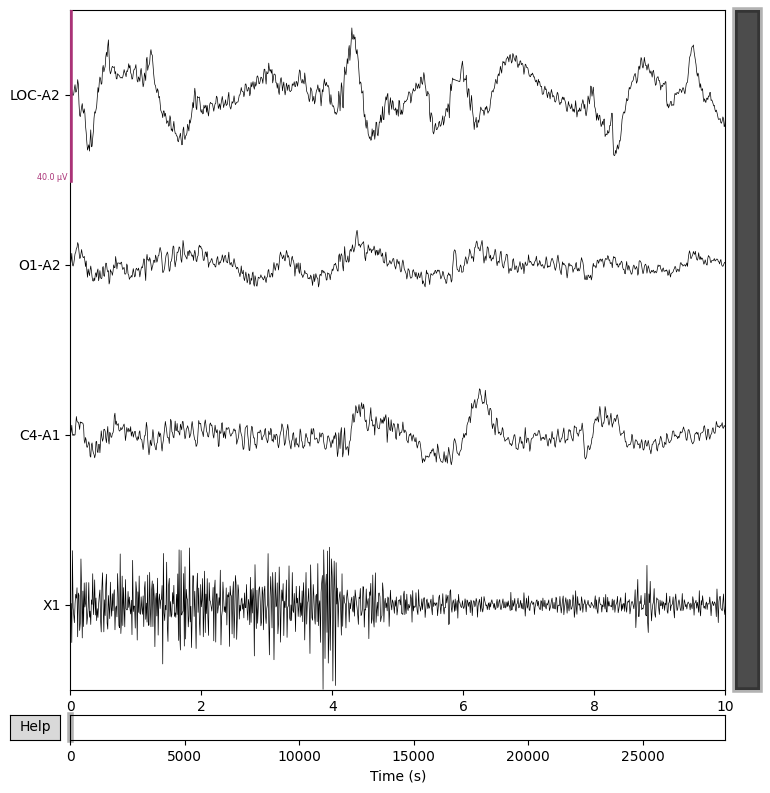

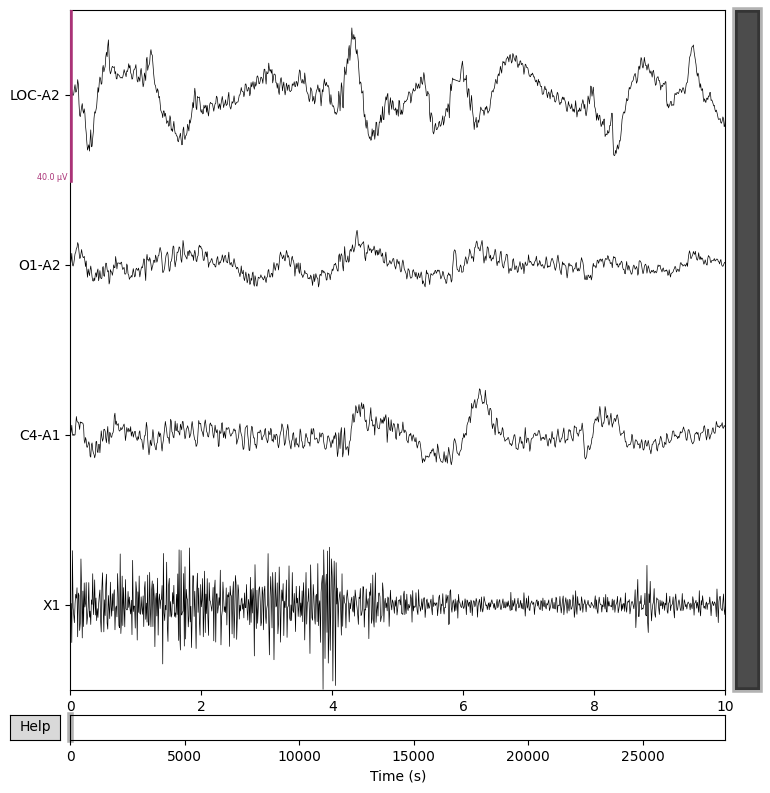

In [51]:
raw_list[0].plot()

In [52]:
raw_list[0].get_data().shape

(4, 2862000)

In [53]:
sf = raw_list[0].info['sfreq']
chan = raw_list[0].ch_names
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')

Chan = ['LOC-A2', 'O1-A2', 'C4-A1', 'X1']
Sampling frequency = 100.0 Hz


Los resultados obtenidos indican que, después de eliminar los canales más irrelevantes, el archivo contiene 4 canales seleccionados y 2862000 muestras por canal, lo que corresponde a la cantidad de puntos de datos grabados tras el remuestreo a 100 Hz.

Esta información nos ha sido útil para confirmar que la dimensionalidad de los datos es la esperada, y para calcular la duración de la grabación, que resulta ser de aproximadamente 7.95 horas (28620 segundos) en este caso. Con esto, nos aseguramos de que los datos están listos para el análisis posterior y de que las operaciones de preprocesamiento han sido aplicadas correctamente.

También debemos tener en cuenta que para acceder directamente a los datos debemos cambiar la escala.

Los datos se escalaron a microvoltios ($\mu V$) y se eliminó un segmento final de 30 minutos, siguiendo referencias del artículo base.

In [54]:
data_list = []
for i, raw in enumerate(raw_list, start=1):
    data = raw.get_data() * 1e6  # microVolts
    data = data[:, :-30 * 30 * 100]  # elimina 30 últimas
    data_list.append(data)
    print(f'Data{i} shape = {data.shape}')

Data1 shape = (4, 2772000)
Data2 shape = (4, 2733000)
Data3 shape = (4, 2382000)
Data4 shape = (4, 2292000)
Data5 shape = (4, 2742000)
Data6 shape = (4, 2469000)
Data7 shape = (4, 2352000)
Data8 shape = (4, 2910000)
Data9 shape = (4, 2817000)
Data10 shape = (4, 2298000)


---

## Etiquetas Fases



CODIFICACIÓN DE LAS FASES EN LOS FICHEROS DE ISRUC-SLEEP Dataset (cuidado porque no hay valor 4 (antiguamente se distinguía una fase más))

* TXT->STAGE
* 0->W
* 1->N1
* 2->N2
* 3->N3
* 5->REM

The default hypnogram format in YASA is a 1D integer vector where:
    
* -2 = Unscored
* -1 = Artefact / Movement
* 0 = Wake
* 1 = N1 sleep
* 2 = N2 sleep
* 3 = N3 sleep
* 4 = REM sleep

En este apartado, hemos trabajado con las etiquetas de las fases del sueño presentes en los registros del ISRUC-Sleep Dataset. Las fases de sueño fueron originalmente codificadas de manera diferente a como lo requiere el formato estándar utilizado por YASA, lo que nos obligó a realizar una adaptación de las etiquetas para asegurar la compatibilidad con las herramientas de análisis posterior.

In [55]:
path_lab1='/content/drive/MyDrive/datos/1/1_1.txt'
path_lab2='/content/drive/MyDrive/datos/2/2_1.txt'
path_lab3='/content/drive/MyDrive/datos/3/3_1.txt'
path_lab4='/content/drive/MyDrive/datos/4/4_1.txt'
path_lab5='/content/drive/MyDrive/datos/5/5_1.txt'
path_lab6='/content/drive/MyDrive/datos/6/6_1.txt'
path_lab7='/content/drive/MyDrive/datos/7/7_1.txt'
path_lab8='/content/drive/MyDrive/datos/8/8_1.txt'
path_lab9='/content/drive/MyDrive/datos/9/9_1.txt'
path_lab10='/content/drive/MyDrive/datos/10/10_1.txt'

paths_labels = [path_lab1, path_lab2, path_lab3, path_lab4, path_lab5,
                path_lab6, path_lab7, path_lab8, path_lab9, path_lab10]

# Cargar las etiquetas y mostrar la distribución
labels_list = []
for i, path in enumerate(paths_labels, start=1):
    labels = pd.read_csv(path, header=None).squeeze("columns")
    labels_list.append(labels)
    print(f"Paciente {i} - Distribución de etiquetas:\n{labels.value_counts()}\n")

Paciente 1 - Distribución de etiquetas:
0
2    373
3    178
0    165
1    119
5    119
Name: count, dtype: int64

Paciente 2 - Distribución de etiquetas:
0
2    323
3    197
5    162
1    144
0    115
Name: count, dtype: int64

Paciente 3 - Distribución de etiquetas:
0
3    317
2    250
5    103
0     89
1     65
Name: count, dtype: int64

Paciente 4 - Distribución de etiquetas:
0
2    234
0    174
3    159
1    137
5     90
Name: count, dtype: int64

Paciente 5 - Distribución de etiquetas:
0
0    302
2    294
3    195
5     81
1     72
Name: count, dtype: int64

Paciente 6 - Distribución de etiquetas:
0
2    296
3    247
1    136
5     96
0     78
Name: count, dtype: int64

Paciente 7 - Distribución de etiquetas:
0
3    262
0    222
2    161
5    101
1     68
Name: count, dtype: int64

Paciente 8 - Distribución de etiquetas:
0
0    376
2    201
5    161
3    143
1    119
Name: count, dtype: int64

Paciente 9 - Distribución de etiquetas:
0
2    365
3    225
1    167
0    149
5     63
N

La distribución de las etiquetas en los datos originales nos da información sobre las fases REM (etiquetadas como 5), estas son menos frecuentes que las fases no REM (N1, N2, N3) y la vigilia (W). Este patrón es común en los registros de sueño, ya que la fase REM ocupa un porcentaje menor del ciclo de sueño. En los registros, las fases N2 y N3 son las más dominantes, seguidas por períodos de vigilia.


Para adaptar los datos al formato estándar de YASA, decidimos cambiar las etiquetas correspondientes a la fase REM de 5 a 4, ya que el valor 5 no está contemplado en el formato de YASA.

Además, aplicamos un ajuste adicional, que consiste en eliminar las últimas 30 muestras de cada conjunto de etiquetas. Esta estrategia se basa en el "Código Ejemplo Polisomnograma".

Al eliminar estas últimas 30 muestras, aseguramos que los datos utilizados para el análisis reflejen de manera más precisa las fases del sueño sin estar contaminados por estas irregularidades.


In [56]:
labels_list_yasa = []

# Modificar etiquetas y eliminar las últimas 30 muestras
for i, labels in enumerate(labels_list, start=1):
    # Cambiar la etiqueta de la fase REM de 5 a 4
    labels = labels.replace(5, 4)

    # Eliminar las últimas 30 muestras de sueño
    labels = labels[:-30]

    print(f"Paciente {i} - Shape después de modificaciones: {labels.shape}")
    labels_list_yasa.append(labels)

Paciente 1 - Shape después de modificaciones: (924,)
Paciente 2 - Shape después de modificaciones: (911,)
Paciente 3 - Shape después de modificaciones: (794,)
Paciente 4 - Shape después de modificaciones: (764,)
Paciente 5 - Shape después de modificaciones: (914,)
Paciente 6 - Shape después de modificaciones: (823,)
Paciente 7 - Shape después de modificaciones: (784,)
Paciente 8 - Shape después de modificaciones: (970,)
Paciente 9 - Shape después de modificaciones: (939,)
Paciente 10 - Shape después de modificaciones: (766,)


Desde el punto de vista clínico, esta adaptación tiene una utilidad clara. Al transformar las etiquetas al formato estándar de YASA, se facilita el uso de herramientas de análisis automatizadas, lo que mejora la precisión y consistencia de los resultados. Las fases del sueño serán identificadas de manera adecuada, lo que permite una interpretación más confiable para el diagnóstico del paciente. Además, al eliminar las últimas 30 muestras, evitamos que intrumentos de los datos afecten el análisis, lo que garantiza que las fases del sueño sean representadas con mayor exactitud. Esta modificación mejora la calidad del análisis del sueño, lo que puede facilitar la detección de posibles trastornos y mejorar la toma de decisiones médicas.

---

## Características

El análisis de las señales EMG, EEG y EOG se complementa con características adicionales como la varianza, los percentiles, el centro de frecuencia, el ancho de banda y el valor central del espectro. Estas variables proporcionan una descripción más detallada y precisa de la actividad en cada canal, lo que es crucial para la clasificación de las etapas del sueño. Por ejemplo, en las fases de sueño REM y NREM, donde las diferencias en las señales pueden ser muy sutiles, estas características mejoran la capacidad de los clasificadores para distinguir entre estas fases.

Por ejemplo, en el caso de las señales EEG, las características espectrales adicionales, como el centro de frecuencia y el ancho de banda, permiten capturar la dinámica de las ondas cerebrales. Esto mejora la capacidad de los clasificadores para identificar estados de sueño como sueño ligero, profundo o REM. Además, las métricas derivadas de las señales EMG y EOG ayudan a identificar movimientos musculares y oculares, lo cual es útil para distinguir artefactos en los datos o para reconocer etapas de sueño donde estos movimientos son más frecuentes.


### Filtro Pasabanda

El filtro pasabanda se aplica a las señales para eliminar frecuencias fuera del rango de interés, mejorando la calidad de las señales EEG, EOG y EMG. Esto es fundamental, ya que las frecuencias fuera de este rango no contienen información relevante para el análisis del sueño.

Este preprocesamiento es clave para obtener señales limpias y confiables, lo que puede reducir los falsos positivos en la clasificación de las etapas del sueño. Al eliminar el ruido y centrarnos en las frecuencias relevantes. Las características derivadas de las señales (como la densidad espectral de potencia y la potencia en diferentes bandas) reflejan mejor los estados fisiológicos del paciente.



In [57]:
freq_broad = (0.5, 45) # filtro pasabanda
win_sec = 30 / freq_broad[0]
sf = 200 # Frecuencia de muestreo
win = int(win_sec * sf) # Duración de la ventana en segundos
kwargs_welch = dict(window="hamming", nperseg=win, average="median")
# Bandas de frecuencia
bands = [(0.4, 1, "sdelta"),
        (1, 4, "fdelta"),
        (4, 8, "theta"),
        (8, 12, "alpha"),
        (12, 16, "sigma"),
        (16, 30, "beta")]

### Análisis de las Señales EMG, EEG y EOG

Empleamos un bucle de procesamiento para iterar sobre los diferentes conjuntos de datos y extraer características de las señales EMG, EEG y EOG. Para cada conjunto de datos, se filtraron las señales, se aplicó una ventana deslizante de 30 segundos y se calcularon diversas métricas estadísticas como la desviación estándar, varianza, percentiles y la densidad espectral de potencia (PSD).

Para el canal EEG, se calcularon características espectrales adicionales como el centro de frecuencia, el ancho de banda y el valor central del espectro, que son fundamentales para la clasificación de las etapas del sueño.

En este paso, se extrajeron características no solo estadísticas, sino también espectrales, lo que mejora la capacidad del modelo para identificar patrones complejos en las señales. Por ejemplo, los percentiles (25, 50 y 75) proporcionan una idea sobre la distribución de la señal, mientras que la PSD permite capturar la energía contenida en diferentes bandas de frecuencia. Estas características, en conjunto, mejoran la capacidad del modelo para discriminar entre diferentes etapas del sueño.

In [58]:
ch_types = np.array(["emg"])
df_emg = pd.DataFrame()
features = []

# Iteramos sobre todos los conjuntos de datos.
for j in range(len(data_list)):
    for i, c in enumerate(ch_types):
    # Preprocesamiento
        # Filtramos los datos con un filtro pasa-banda
        dt_filt = filter_data(
            data_list[j][i+2, :],        # Selección de datos.
            sf,                      # Frecuencia de muestreo.
            l_freq=freq_broad[0],    # Frecuencia de corte inferior.
            h_freq=freq_broad[1],    # Frecuencia de corte superior.
            verbose=False
        )
        # Extraemos segmentos de los datos con una ventana deslizante
        times, epochs = sliding_window(dt_filt, sf=sf, window=30)

        # Inicializamos un diccionario para las características estadísticas
        feat = {
            "std": np.std(epochs, ddof=1, axis=1),
            "var": np.var(epochs, axis=1)
                }

        # Calculamos los percentiles 25, 50 y 75
        percentiles = np.percentile(epochs, [25, 50, 75], axis=1)
        feat["percentile25"] = percentiles[0]
        feat["percentile50"] = percentiles[1]
        feat["percentile75"] = percentiles[2]

        # Calculamos la PSD (densidad espectral de potencia)
        freqs, psd = sp_sig.welch(epochs, sf, **kwargs_welch)

        # Si el canal no es EMG, calculamos la potencia en cada banda
        if c != "emg":
            bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
            for j, (_, _, b) in enumerate(bands):
                feat[b] = bp[j]


        # Si el canal es EEG, calculamos características espectrales adicionales
        if c == "eeg":
            for j, (low, high, band_name) in enumerate(bands):
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                center_frequency = np.sum(freqs[idx_band] * psd[:, idx_band], axis=1) / np.sum(psd[:, idx_band], axis=1)
                bandwidth = np.trapz(psd[:, idx_band], dx=(freqs[1] - freqs[0]), axis=1)
                center_value = np.max(psd[:, idx_band], axis=1)

            # Añadimos las características calculadas al diccionario
            feat[band_name + "_center_frequency"] = center_frequency
            feat[band_name + "_bandwidth"] = bandwidth
            feat[band_name + "_center_value"] = center_value


        # Convertimos el diccionario de características en un DataFrame.
        feat = pd.DataFrame(feat).add_prefix(c + "_")
        features.append(feat)

# Concatenamos todas las características de EMG en un solo DataFrame
df_emg = pd.concat([df_emg] + features, ignore_index=True)
df_emg

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 12000 is greater than input length  = 6000, using nperseg = 6000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


,emg_std,emg_var,emg_percentile25,emg_percentile50,emg_percentile75
0,1.819705,3.310776,-1.024666,-0.029806,0.982646
1,4.974756,24.744076,-1.502100,-0.007405,1.572924
2,1.917133,3.674786,-0.818913,-0.010632,0.825478
3,1.109875,1.231616,-0.727699,-0.025554,0.676829
4,1.048455,1.099074,-0.690224,-0.012875,0.667626
...,...,...,...,...,...
4288,1.259787,1.586798,-0.736097,0.016742,0.697144
4289,1.225752,1.502217,-0.806357,0.011360,0.810061
4290,1.533576,2.351465,-0.921733,-0.001585,0.901244
4291,1.117957,1.249619,-0.702621,-0.018497,0.663679


**Análisis de las señales de EMG (actividad muscular):**

1. **Desviación estándar (emg_std):**  
   Valores altos indican actividad muscular más pronunciada, asociada a movimientos periódicos de las extremidades o bruxismo durante el sueño, lo cual es relevante para detectar trastornos relacionados con movimientos involuntarios en el sueño.

2. **Percentiles (P25, P50, P75):**  
   Muestran una variabilidad moderada en los movimientos musculares. Valores más altos pueden estar presentes en trastornos como el síndrome de piernas inquietas o los movimientos periódicos de las extremidades.

In [59]:
ch_types = np.array(["eeg"])
df_eeg = pd.DataFrame()
features = []

# Iteramos sobre todos los conjuntos de datos.
for j in range(len(data_list)):
    for i, c in enumerate(ch_types):
    # Preprocesamiento
        # Filtramos los datos con un filtro pasa-banda
        dt_filt = filter_data(
            data_list[j][i+1, :],        # Selección de datos.
            sf,                      # Frecuencia de muestreo.
            l_freq=freq_broad[0],    # Frecuencia de corte inferior.
            h_freq=freq_broad[1],    # Frecuencia de corte superior.
            verbose=False
        )
        # Extraemos segmentos de los datos con una ventana deslizante
        times, epochs = sliding_window(dt_filt, sf=sf, window=30)

        # Inicializamos un diccionario para las características estadísticas
        feat = {
            "std": np.std(epochs, ddof=1, axis=1),
            "var": np.var(epochs, axis=1)
                }

        # Calculamos los percentiles 25, 50 y 75
        percentiles = np.percentile(epochs, [25, 50, 75], axis=1)
        feat["percentile25"] = percentiles[0]
        feat["percentile50"] = percentiles[1]
        feat["percentile75"] = percentiles[2]

        # Calculamos la PSD (densidad espectral de potencia)
        freqs, psd = sp_sig.welch(epochs, sf, **kwargs_welch)

        # Si el canal no es EMG, calculamos la potencia en cada banda
        if c != "emg":
            bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
            for j, (_, _, b) in enumerate(bands):
                feat[b] = bp[j]


        # Si el canal es EEG, calculamos características espectrales adicionales
        if c == "eeg":
            for j, (low, high, band_name) in enumerate(bands):
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                center_frequency = np.sum(freqs[idx_band] * psd[:, idx_band], axis=1) / np.sum(psd[:, idx_band], axis=1)
                bandwidth = np.trapz(psd[:, idx_band], dx=(freqs[1] - freqs[0]), axis=1)
                center_value = np.max(psd[:, idx_band], axis=1)

            # Añadimos las características calculadas al diccionario
            feat[band_name + "_center_frequency"] = center_frequency
            feat[band_name + "_bandwidth"] = bandwidth
            feat[band_name + "_center_value"] = center_value


        # Convertimos el diccionario de características en un DataFrame.
        feat = pd.DataFrame(feat).add_prefix(c + "_")
        features.append(feat)

# Concatenamos todas las características de EEG en un solo DataFrame
df_eeg = pd.concat([df_eeg] + features, ignore_index=True)
df_eeg

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 12000 is greater than input length  = 6000, using nperseg = 6000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


,eeg_std,eeg_var,eeg_percentile25,eeg_percentile50,eeg_percentile75,eeg_sdelta,eeg_fdelta,eeg_theta,eeg_alpha,eeg_sigma,eeg_beta,eeg_beta_center_frequency,eeg_beta_bandwidth,eeg_beta_center_value
0,1.500494,2.251106,-0.912695,0.006060,0.884564,0.065696,0.255703,0.083073,0.034903,0.030688,0.529937,21.975207,0.838955,1.062575
1,4.016926,16.133007,-1.230681,0.047258,1.360896,0.253057,0.427746,0.139593,0.029895,0.023029,0.126679,23.122274,1.157743,0.575896
2,2.026229,4.104919,-0.844196,0.001144,0.836274,0.050778,0.185188,0.073374,0.046605,0.034205,0.609851,23.024768,0.668431,0.661963
3,1.191570,1.419603,-0.728808,-0.013127,0.732522,0.029352,0.095757,0.066354,0.036653,0.042226,0.729658,23.336683,0.699634,0.683597
4,1.197440,1.433624,-0.774560,-0.012429,0.775735,0.036507,0.147277,0.079983,0.043651,0.038327,0.654254,23.351620,0.468082,0.606246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,1.008433,1.016767,-0.649145,-0.011365,0.626862,0.050486,0.363933,0.260395,0.133201,0.090756,0.101230,20.580157,0.102086,0.080007
4289,1.151634,1.326040,-0.784481,-0.019295,0.781518,0.114878,0.323278,0.220737,0.103702,0.083555,0.153850,24.197904,0.225452,0.292118
4290,1.255493,1.576001,-0.731148,0.035937,0.765446,0.069785,0.341689,0.272548,0.104384,0.087675,0.123919,23.327882,0.147491,0.101764
4291,0.990757,0.981436,-0.610692,-0.024299,0.596983,0.057315,0.295010,0.255223,0.120853,0.115775,0.155825,19.805854,0.120663,0.096166


**Análisis de las señales de EEG (actividad cerebral):**

1. **Desviación estándar (eeg_std):**  
   Los valores varían entre 0.99 y 4.02, indicando alta variabilidad en la actividad cerebral. Los valores altos están asociados con mayor actividad cerebral, típica en fases de sueño ligero o vigilia, mientras que los valores bajos pueden reflejar fases de sueño profundo (delta) con actividad más estable.

2. **Percentiles (P25, P50, P75):**  
   Los percentiles muestran amplitudes moderadas de las señales cerebrales. En la fase REM, la variabilidad aumenta, y el percentil 50 refleja la actividad cerebral media, relacionada con fases de sueño ligero o profundo.

3. **Potencia de las bandas (eeg_sdelta, eeg_fdelta, eeg_theta, eeg_alpha, eeg_beta):**  
   - **Delta:** Potencia baja, indicando sueño ligero o vigilia.  
   - **Theta:** Potencia baja, con algunos aumentos que podrían correlacionarse con transiciones de sueño ligero.  
   - **Alfa y Beta:** Los picos en la banda beta sugieren mayor vigilia o actividad cerebral en sueño ligero, útil para detectar trastornos como por ejemplo el insomnio.  
   - **Centro de frecuencia de Beta:** Varía entre 19-24 Hz, típico de la vigilia.

In [60]:
ch_types = np.array(["eog"])
df_eog = pd.DataFrame()
features = []

# Iteramos sobre todos los conjuntos de datos.
for j in range(len(data_list)):
    for i, c in enumerate(ch_types):
    # Preprocesamiento
        # Filtramos los datos con un filtro pasa-banda
        dt_filt = filter_data(
            data_list[j][i, :],        # Selección de datos.
            sf,                    # Frecuencia de muestreo.
            l_freq=freq_broad[0],  # Frecuencia de corte inferior.
            h_freq=freq_broad[1],  # Frecuencia de corte superior.
            verbose=False
        )
        # Extraemos segmentos de los datos con una ventana deslizante
        times, epochs = sliding_window(dt_filt, sf=sf, window=30)

        # Inicializamos un diccionario para las características estadísticas
        feat = {
            "std": np.std(epochs, ddof=1, axis=1),
            "var": np.var(epochs, axis=1)
                }

        # Calculamos los percentiles 25, 50 y 75
        percentiles = np.percentile(epochs, [25, 50, 75], axis=1)
        feat["percentile25"] = percentiles[0]
        feat["percentile50"] = percentiles[1]
        feat["percentile75"] = percentiles[2]

        # Calculamos la PSD (densidad espectral de potencia)
        freqs, psd = sp_sig.welch(epochs, sf, **kwargs_welch)

        # Si el canal no es EMG, calculamos la potencia en cada banda
        if c != "emg":
            bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
            for j, (_, _, b) in enumerate(bands):
                feat[b] = bp[j]


        # Si el canal es EEG, calculamos características espectrales adicionales
        if c == "eeg":
            for j, (low, high, band_name) in enumerate(bands):
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                center_frequency = np.sum(freqs[idx_band] * psd[:, idx_band], axis=1) / np.sum(psd[:, idx_band], axis=1)
                bandwidth = np.trapz(psd[:, idx_band], dx=(freqs[1] - freqs[0]), axis=1)
                center_value = np.max(psd[:, idx_band], axis=1)

            # Añadimos las características calculadas al diccionario
            feat[band_name + "_center_frequency"] = center_frequency
            feat[band_name + "_bandwidth"] = bandwidth
            feat[band_name + "_center_value"] = center_value


        # Convertimos el diccionario de características en un DataFrame.
        feat = pd.DataFrame(feat).add_prefix(c + "_")
        features.append(feat)

# Concatenamos todas las características de EOG en un solo DataFrame
df_eog = pd.concat([df_eog] + features, ignore_index=True)
df_eog

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 12000 is greater than input length  = 6000, using nperseg = 6000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


,eog_std,eog_var,eog_percentile25,eog_percentile50,eog_percentile75,eog_sdelta,eog_fdelta,eog_theta,eog_alpha,eog_sigma,eog_beta
0,3.309180,10.948849,-1.257512,-0.056131,1.258415,0.173360,0.645197,0.109384,0.019142,0.015346,0.037571
1,3.243679,10.519700,-1.328030,-0.013027,1.386624,0.316045,0.448842,0.052525,0.027184,0.016815,0.138589
2,2.123279,4.507564,-0.894714,0.004081,0.911622,0.097753,0.534131,0.087191,0.021754,0.018807,0.240366
3,1.169890,1.368415,-0.707702,0.000021,0.736790,0.118327,0.470912,0.072155,0.026400,0.024915,0.287291
4,1.027147,1.054856,-0.667142,0.005384,0.689323,0.090180,0.246403,0.082457,0.030013,0.037310,0.513637
...,...,...,...,...,...,...,...,...,...,...,...
4288,1.042525,1.086677,-0.658498,-0.037181,0.637441,0.104061,0.454921,0.218495,0.081133,0.057955,0.083434
4289,1.057240,1.117570,-0.677765,-0.004433,0.686830,0.077444,0.505517,0.223132,0.070010,0.052657,0.071239
4290,1.188321,1.411871,-0.768458,-0.022049,0.741302,0.076387,0.506658,0.212207,0.083696,0.060209,0.060843
4291,0.963761,0.928681,-0.604748,-0.017967,0.581815,0.131122,0.370356,0.209143,0.084985,0.087238,0.117155


**Análisis de las señales de EOG (movimientos oculares):**

1. **Desviación estándar (eog_std):**  
   La desviación estándar y la varianza indican la cantidad de variabilidad en los movimientos oculares. En la primera fila, la desviación estándar es 3.309 y la varianza es 10.948, lo que sugiere que la señal de EOG tiene fluctuaciones significativas, lo cual es esperado dado que los movimientos oculares pueden ser bastante dinámicos y con alta variabilidad.

2. **Percentiles (P25, P50, P75):**  
   Los percentiles reflejan la amplitud de los movimientos oculares. En la fase REM, los movimientos suelen ser más amplios y variables, como se observa en el percentil 75, que es más alto en comparación con el percentil 25.

3. **Frecuencias Delta, Theta, Alfa, Beta:**  
   Las bandas delta y theta son bajas, lo que es característico del sueño no REM. Sin embargo, las frecuencias alfa y beta tienden a aumentar en la fase REM, lo que ayuda a correlacionar los movimientos oculares con la actividad cerebral del EEG.

En conclusión, el análisis de las señales de EMG, EEG y EOG proporciona información valiosa sobre las fases del sueño y posibles trastornos. La variabilidad en los movimientos oculares (EOG) y la actividad cerebral (EEG) es característica de las fases REM y no REM del sueño, lo que permite identificar transiciones y patrones asociados a trastornos. La actividad muscular (EMG) es relevante para detectar otros trastornosrelacionados con la actividad muscular, al observar aumentos en la variabilidad y la actividad. Estos análisis pueden ofrecer una ventaja significativa sobre el método manual al proporcionar resultados más rápidos y objetivos en la evaluación del sueño.

### Etiquetado del sueño

El etiquetado del sueño se realizó utilizando la función SleepStaging de la librería YASA. Dado que tenemos varios registros de diferentes pacientes, se aplicó un bucle para iterar sobre los datos y obtener las características de cada uno de ellos de manera eficiente. Esta estrategia permite procesar múltiples registros sin tener que hacer el etiquetado manualmente, lo cual es un ahorro significativo de tiempo y esfuerzo.

La función SleepStaging de la librería YASA no permite seleccionar múltiples canales, por lo que, en el caso de eeg, elegimos el canal C4-A1. Este canal está más relacionado con la actividad cerebral general durante el sueño en comparación con canales como O1-A2. Para los demás, seleccionamos EOG con LOC-A2 y EMG con X1. Estos canales son ampliamente utilizados en estudios de sueño, lo que nos permite obtener un etiquetado de las etapas del sueño preciso y confiable.

In [61]:
sls_list = []
for i, raw in enumerate(raw_list, start=1):
    sls = yasa.SleepStaging(raw, eeg_name='C4-A1', eog_name='LOC-A2', emg_name='X1')
    sls_list.append(sls)
    print(f"Forma de sls{i}:", sls.get_features().shape)

Forma de sls1: (954, 149)
Forma de sls2: (941, 149)
Forma de sls3: (824, 149)
Forma de sls4: (794, 149)
Forma de sls5: (944, 149)
Forma de sls6: (853, 149)
Forma de sls7: (814, 149)
Forma de sls8: (1000, 149)
Forma de sls9: (969, 149)
Forma de sls10: (796, 149)


Cada objeto sls generado tiene una forma diferente, lo que refleja la cantidad de épocas procesadas para cada paciente. El número de épocas varía dependiendo de la duración del registro, la calidad de los datos y la frecuencia de muestreo. Los tamaños van desde 794 hasta 1000 épocas por paciente, lo que sugiere que los registros de los pacientes tienen una longitud y número de muestras variadas.

Eliminamos las 30 últimas épocas para que los registros sean más consistentes y menos propensos a errores que puedan ocurrir al final de la grabación. Esto es un paso necesario para mejorar la calidad y fiabilidad del etiquetado del sueño.

In [62]:
for i, sls in enumerate(sls_list, start=1):
    sls = sls.get_features()[:-30]  # Eliminamos las 30 últimas épocas
    sls_list[i-1] = sls  # Reemplazamos el objeto en la lista
    print(f"Forma de sls{i} después de eliminar las 30 últimas épocas:", sls.shape)

Forma de sls1 después de eliminar las 30 últimas épocas: (924, 149)
Forma de sls2 después de eliminar las 30 últimas épocas: (911, 149)
Forma de sls3 después de eliminar las 30 últimas épocas: (794, 149)
Forma de sls4 después de eliminar las 30 últimas épocas: (764, 149)
Forma de sls5 después de eliminar las 30 últimas épocas: (914, 149)
Forma de sls6 después de eliminar las 30 últimas épocas: (823, 149)
Forma de sls7 después de eliminar las 30 últimas épocas: (784, 149)
Forma de sls8 después de eliminar las 30 últimas épocas: (970, 149)
Forma de sls9 después de eliminar las 30 últimas épocas: (939, 149)
Forma de sls10 después de eliminar las 30 últimas épocas: (766, 149)


Tras la eliminación, el tamaño de los objetos sls disminuye en 30 épocas, como se observa en los resultados. La forma de los objetos después de la eliminación varía entre 764 y 970 épocas, dependiendo del número inicial de épocas en cada registro.

---

## Conjuntos de entrenamiento y test

En esta parte del proceso, se asignan los registros de los pacientes a los conjuntos de entrenamiento y prueba. Los registros de los pacientes 3 a 10 se utilizan para entrenamiento, mientras que los registros de los pacientes 1 y 2 se asignan al conjunto de prueba. Esta estrategia de partición no es aleatoria y no emplea técnicas como validación cruzada o hold-out. En lugar de ello, se optó por una asignación fija para asegurar que la evaluación se realice con datos no vistos por el modelo durante el entrenamiento, lo que permite medir su capacidad de generalización.

In [63]:
# Cargar datos de entrenamiento y test
X_train = pd.concat([sls_list[2],sls_list[3], sls_list[4],sls_list[5],
                     sls_list[6],sls_list[7],sls_list[8],sls_list[9]],
                    ignore_index=True)
X_test = pd.concat([sls_list[0],sls_list[1]], ignore_index=True)
print(X_train.shape, X_test.shape)

(6754, 149) (1835, 149)


In [64]:
# Cargar las etiquetas correspondientes
y_train = pd.concat([labels_list_yasa[2], labels_list_yasa[3], labels_list_yasa[4],
                     labels_list_yasa[5], labels_list_yasa[6], labels_list_yasa[7],
                     labels_list_yasa[8], labels_list_yasa[9]],
                    ignore_index=True)
y_test = pd.concat([labels_list_yasa[0], labels_list_yasa[1]], ignore_index=True)
print(y_train.shape, y_test.shape)

(6754,) (1835,)


Al cargar los datos de entrenamiento y prueba, se concatenan los registros de los pacientes para formar los conjuntos de datos completos. El conjunto de entrenamiento contiene 6754 muestras y el conjunto de prueba tiene 1835 muestras. Esto proporciona un tamaño adecuado para entrenar un modelo robusto y evaluar su rendimiento de manera representativa. Es importante señalar que esta estrategia de partición fija, aunque más simple, podría estar influenciada por los datos de los pacientes seleccionados, lo que puede no reflejar la variabilidad de la población general. Sin embargo, como los datos provienen de múltiples pacientes, la estrategia sigue siendo válida y útil.

La decisión de no binarizar ni normalizar los datos se justifica por las características de XGBoost. Este tipo de modelo es robusto a las diferencias en las escalas de las características y no requiere normalización para funcionar correctamente. Además, este puede manejar directamente la clasificación multiclase con etiquetas enteras, por lo que la binarización de las etiquetas no es necesaria. Esta estrategia simplifica el proceso sin afectar el rendimiento del modelo, permitiendo un flujo de trabajo más eficiente.

---

## Modelado

En esta fase, definimos y entrenamos un modelo de clasificación multiclase utilizando XGBoost, un algoritmo popular que combina árboles de decisión con técnicas de optimización avanzadas.

Los parámetros ajustados para la clasificación multiclase incluyen una tasa de aprendizaje baja y una profundidad máxima de árbol reducida, lo que busca evitar el sobreajuste y garantizar que el modelo generalice bien a nuevos datos. También se emplean técnicas como el submuestreo (subsample) y el muestreo de columnas (colsample_bytree) para prevenir el sobreajuste, lo que es crucial en modelos con muchos parámetros y potencial de sobreajuste.

In [65]:
# Parámetros ajustados para clasificación multiclase
params = {
    'objective': 'multi:softprob',  # Clasificación multiclase
    'num_class': 5,  # Número de clases
    'learning_rate': 0.005,  # Tasa de aprendizaje
    'max_depth': 4,  # Profundidad del árbol
    'n_estimators': 300,  # Número de árboles
    'subsample': 0.7,  # Submuestreo
    'colsample_bytree': 0.7,  # Submuestreo de columnas
    'gamma': 0.2,  # Control de la complejidad del modelo
    'alpha': 0.5,  # Regularización L1
    'lambda': 1.5,  # Regularización L2
    'random_state': 42  # Semilla para la reproducibilidad
}

# Instanciar el clasificador XGBoost
xgb_clf = XGBClassifier(**params)

La validación cruzada la utilizamos para evaluar el rendimiento del modelo en diferentes particiones del conjunto de entrenamiento. Al dividir los datos en 5 pliegues y realizar la validación, se obtiene una evaluación más robusta del rendimiento del modelo, ya que no depende de una única división de los datos.

In [66]:
# Dividir los datos en 5 pliegues para la validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista para guardar los scores y las predicciones
cv_scores = []
auc_scores = []
y_true_dev = []  # Lista para almacenar las etiquetas verdaderas del conjunto de desarrollo
y_pred_dev = []  # Lista para almacenar las predicciones del conjunto de desarrollo

# Realizar la validación cruzada
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Ajustar el modelo
    xgb_clf.fit(X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)], verbose=False)

    # Predecir las probabilidades para AUC
    y_val_prob = xgb_clf.predict_proba(X_val_fold)

    # Predecir las clases para la precisión
    y_val_pred = xgb_clf.predict(X_val_fold)

    # Calcular AUC por clase y agregar al listado
    for i in range(params['num_class']):
        auc = roc_auc_score(y_val_fold == i, y_val_prob[:, i])  # AUC por clase
        print(f"AUC para la clase {i}: {auc:.4f}")
        auc_scores.append(auc)

    # Calcular precisión para el conjunto de validación
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_scores.append(accuracy)

    # Almacenar las etiquetas y predicciones para análisis posterior
    y_true_dev.extend(y_val_fold)
    y_pred_dev.extend(y_val_pred)

# Mostrar los resultados de la validación cruzada
print(f'\nAccuracy medio en validación cruzada: {np.mean(cv_scores):.4f}')
print(f'AUC promedio en validación cruzada: {np.mean(auc_scores):.4f}')

print("\nClassification Report para el conjunto de desarrollo (Entrenamiento + Validación):")
print(classification_report(y_true_dev, y_pred_dev))

AUC para la clase 0: 0.9914
AUC para la clase 1: 0.9311
AUC para la clase 2: 0.9508
AUC para la clase 3: 0.9939
AUC para la clase 4: 0.9946
AUC para la clase 0: 0.9932
AUC para la clase 1: 0.9203
AUC para la clase 2: 0.9650
AUC para la clase 3: 0.9965
AUC para la clase 4: 0.9916
AUC para la clase 0: 0.9899
AUC para la clase 1: 0.9235
AUC para la clase 2: 0.9553
AUC para la clase 3: 0.9941
AUC para la clase 4: 0.9907
AUC para la clase 0: 0.9879
AUC para la clase 1: 0.9373
AUC para la clase 2: 0.9504
AUC para la clase 3: 0.9928
AUC para la clase 4: 0.9943
AUC para la clase 0: 0.9870
AUC para la clase 1: 0.9257
AUC para la clase 2: 0.9591
AUC para la clase 3: 0.9952
AUC para la clase 4: 0.9885

Accuracy medio en validación cruzada: 0.8454
AUC promedio en validación cruzada: 0.9720

Classification Report para el conjunto de desarrollo (Entrenamiento + Validación):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1412
           1      

El modelo mostró un rendimiento general sólido con un accuracy de 0.8454 y un AUC promedio de 0.9720. Los mejores resultados fueron en las clases 0 y 3, con alta precisión, recall y f1-score, indicando un buen desempeño en estas clases más representadas. La clase 1, sin embargo, mostró un rendimiento más bajo con un f1-score de 0.60, sugiriendo dificultades en la clasificación de esta etapa del sueño, posiblemente debido a su menor representación.

En resumen, el modelo tiene una buena capacidad de discriminación, pero necesita mejoras para manejar mejor las clases menos frecuentes, como la clase 1.

In [67]:
# Ahora entrenamos el modelo con todo el conjunto de desarrollo (entrenamiento + validación) y evaluamos en el conjunto de test
xgb_clf.fit(X_train, y_train, verbose=False)

# Predicciones en el conjunto de test
y_test_pred = xgb_clf.predict(X_test)
y_test_prob = xgb_clf.predict_proba(X_test)

# AUC por clase para el conjunto de test
for i in range(params['num_class']):
    auc_class = roc_auc_score(y_test == i, y_test_prob[:, i])  # AUC por clase
    print(f"AUC para la clase {i} (Test): {auc_class:.4f}")

# AUC para el conjunto de test
auc_test = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
print(f'\nAUC para el conjunto de test: {auc_test:.4f}')

# Precisión para el conjunto de test
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy para el conjunto de test: {accuracy_test:.4f}')

# Informe de clasificación para el conjunto de test
print("\nClassification Report para el conjunto de test:")
print(classification_report(y_test, y_test_pred))


AUC para la clase 0 (Test): 0.9841
AUC para la clase 1 (Test): 0.8920
AUC para la clase 2 (Test): 0.9465
AUC para la clase 3 (Test): 0.9785
AUC para la clase 4 (Test): 0.9905

AUC para el conjunto de test: 0.9583
Accuracy para el conjunto de test: 0.8082

Classification Report para el conjunto de test:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       262
           1       0.74      0.29      0.41       255
           2       0.78      0.91      0.84       692
           3       0.90      0.85      0.87       375
           4       0.84      0.91      0.87       251

    accuracy                           0.81      1835
   macro avg       0.81      0.77      0.77      1835
weighted avg       0.81      0.81      0.79      1835



En el conjunto de test, el modelo alcanzó un accuracy de 0.8082 y un AUC de 0.9583. Los mejores resultados fueron en las clases 3 y 4, con precisión y recall altos, lo que demuestra una clasificación efectiva para estas etapas del sueño. Sin embargo, la clase 1 continuó mostrando un bajo rendimiento con un f1-score de 0.41, destacando la necesidad de mejorar la identificación de esta etapa. A pesar de esto, el modelo sigue siendo robusto y útil para la clasificación automática de las etapas del sueño en datos no vistos, con un alto AUC que respalda su capacidad de discriminación.

### Selección de las 10 variables más importantes

XGBoost ofrece varios métodos para medir la importancia de las variables:

-  Weight: Mide cuántas veces se utiliza una variable en los árboles.

-  Gain: Calcula el aporte promedio al valor de pérdida para las divisiones que usan una característica.

-  Cover: Mide la cobertura promedio de las muestras observadas para una característica.

Con el objetivo de simplificar el modelo y hacerlo más interpretativo, se decidió seleccionar solo las 10 características más importantes en base al Gain. Este paso también puede mejorar la eficiencia del modelo, ya que se reducen los costos computacionales y se facilita la interpretación de los resultados.


DataFrame de Importancia de Variables:
                     Variable  Importancia
40         eeg_nzc_c7min_norm   626.231873
31        eeg_hmob_c7min_norm   374.898987
43        eeg_perm_c7min_norm   306.291748
27                eeg_higuchi   215.942810
44        eeg_perm_p2min_norm   177.514191
82         emg_nzc_c7min_norm   169.664230
47   eeg_petrosian_p2min_norm   169.259277
21                 eeg_fdelta   145.474991
142        eog_std_c7min_norm   116.004738
71     emg_higuchi_p2min_norm   105.155212


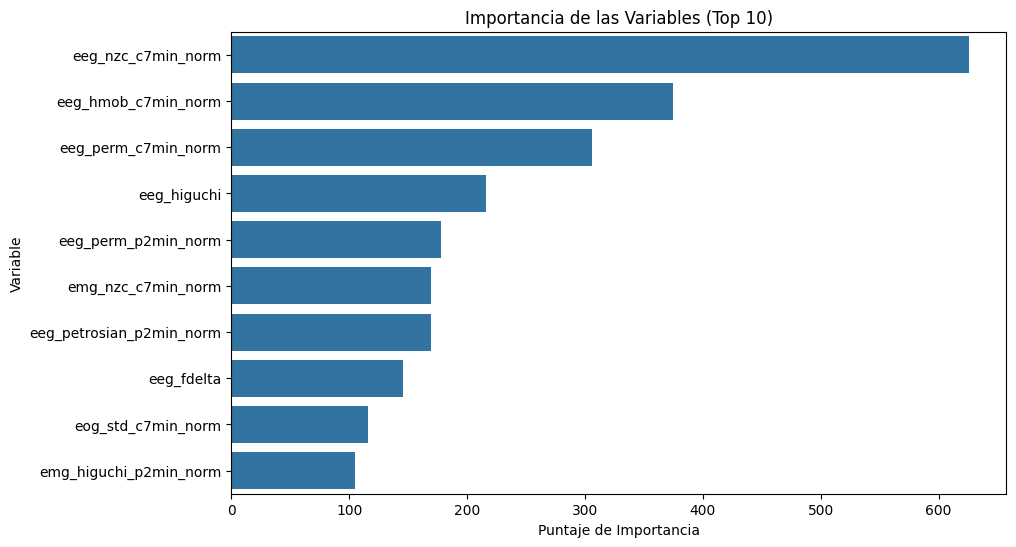

In [68]:
# Importancia de las características
importance = xgb_clf.get_booster().get_score(importance_type='gain')

# Ordenar las variables por importancia
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Crear un DataFrame con la importancia de las características
importance_df = pd.DataFrame({
    'Variable': list(importance.keys()),
    'Importancia': list(importance.values())
})
importance_df = importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar el DataFrame
print("\nDataFrame de Importancia de Variables:")
print(importance_df.head(10))

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
seaborn.barplot(x='Importancia', y='Variable', data=importance_df.head(10))
plt.title('Importancia de las Variables (Top 10)')
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Variable')
plt.show()

Los resultados sugieren que la actividad cerebral (EEG) y muscular (EMG) son los principales indicadores para clasificar las fases del sueño. Además, el uso de variables calculadas en diferentes escalas temporales (2 minutos y 7 minutos) demuestra que tanto los patrones a largo plazo como las transiciones rápidas son esenciales para el modelo.

Variables como eeg_fdelta y eog_std_c7min_norm están directamente asociadas con patrones característicos de fases específicas, como las ondas delta en el sueño profundo o los movimientos oculares en REM.

La importancia de las variables muestra que el modelo no solo utiliza métricas esperadas por los clínicos (como ondas delta y movimientos oculares), sino que también aprovecha características avanzadas como dimensiones fractales y entropías para capturar patrones sutiles en los datos. Esta combinación de información compleja respalda la utilidad del modelo en contextos clínicos, haciendo que sea más interpretable y confiable para los especialistas.

Una vez seleccionadas las características más importantes, entrenamos un nuevo modelo utilizando solo esas variables.

In [69]:
# Seleccionar las 10 variables más importantes
important_features = importance_df['Variable'].head(10).tolist()

# Crear un nuevo conjunto de datos con solo las variables más importantes
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Ajustar un nuevo modelo con el conjunto reducido
xgb_clf_reduced = XGBClassifier(**params)
xgb_clf_reduced.fit(X_train_reduced, y_train)

# Evaluar el modelo reducido
y_test_pred_reduced = xgb_clf_reduced.predict(X_test_reduced)
print("\nClassification Report (Modelo Reducido):")
print(classification_report(y_test, y_test_pred_reduced))



Classification Report (Modelo Reducido):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       262
           1       0.50      0.20      0.28       255
           2       0.71      0.92      0.80       692
           3       0.94      0.73      0.82       375
           4       0.78      0.84      0.81       251

    accuracy                           0.76      1835
   macro avg       0.75      0.71      0.71      1835
weighted avg       0.75      0.76      0.74      1835



La decisión de optar por el modelo completo, que utiliza todas las variables disponibles, se justifica principalmente por la necesidad de maximizar la precisión y la fiabilidad del modelo, especialmente en un contexto médico donde la correcta clasificación de los pacientes es crucial. Al comparar el modelo completo y el modelo reducido, se observa una ligera pérdida en el rendimiento global. El accuracy del modelo completo es 0.81, mientras que el del modelo reducido es 0.76. Esto indica que la reducción de variables ha tenido un impacto negativo en la capacidad del modelo para predecir correctamente los datos de test.

Si nos fijamos en el rendimiento por clases, podemos ver diferencias notables entre los modelos:

- Clase 0: El modelo reducido mantiene una buena precisión y recall, con valores cercanos a los del modelo completo. Esto indica que las variables excluidas no eran cruciales para la identificación de esta clase.
  
- Clase 1: En esta clase, el recall ha caído de 0.29 en el modelo completo a 0.20 en el modelo reducido, lo que sugiere que las variables excluidas eran cruciales para identificar correctamente esta clase. Esta disminución en el rendimiento refleja la importancia de estas variables para clasificar adecuadamente esta etapa del sueño.

- Clase 2: Aunque el recall mejora ligeramente, la precisión y el f1-score empeoran, lo que refleja un balance desfavorable entre precisión y recall tras la reducción. Esto indica que la eliminación de ciertas variables ha afectado negativamente la capacidad de identificar correctamente los registros de esta clase.

- Clase 3 y Clase 4: Estas clases muestran un rendimiento similar en ambos modelos, lo que sugiere que no dependen tanto de las variables excluidas.

En conclusión, dado el contexto clínico y la necesidad de un modelo confiable para clasificar con precisión todas las fases del sueño, la estrategia óptima es utilizar el modelo con todas las variables.



---



## Interpretabilidad

La interpretabilidad es un elemento central para garantizar que el modelo de clasificación de fases del sueño no solo sea efectivo, sino también comprensible y defendible ante clínicos y expertos. A continuación, se mostramos las estrategias de interpretación seguidas, utilizando ejemplos y visualizaciones que muestran el desempeño del modelo.

### Análisis con SHAP

El uso de SHAP nos permitirá una perspectiva detallada sobre cómo las características del modelo interactúan y afectan las predicciones. Esto proporciona una justificación clara y numérica sobre las decisiones del modelo, ayudando a los médicos a entender cómo se toman las decisiones.


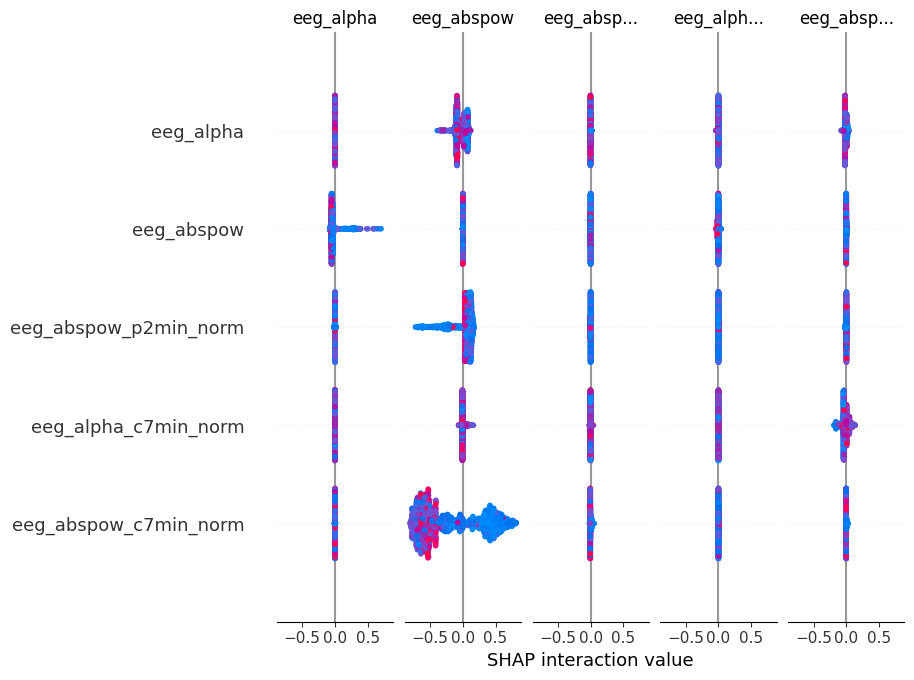

In [70]:
# Crear el objeto explainer de SHAP para XGBoost
explainer = shap.TreeExplainer(xgb_clf)

# Calcular valores SHAP para el conjunto de test
shap_values = explainer.shap_values(X_test)

# Gráfico de dispersión: Contribuciones individuales por variable
shap.summary_plot(shap_values, X_test)

Las observaciones clave son las siguientes:

**Dispersión de los puntos:**
  
La dispersión horizontal (valores SHAP) muestra el impacto que las interacciones de cada característica tienen en las predicciones.
  
Una mayor dispersión indica que la interacción de la variable con otras tiene un efecto significativo en las decisiones del modelo.
  
Por ejemplo, la variable eeg_abspow_c7min_norm presenta una gran dispersión, lo que sugiere que sus interacciones con otras variables son cruciales para el modelo.

**Densidad de los Puntos:**

Las áreas con mayor densidad de puntos reflejan combinaciones de valores que son frecuentes en el conjunto de datos.

En la variable eeg_abspow_p2min_norm, se observa una concentración de puntos en un rango específico, lo que implica que esta interacción ocurre con regularidad y tiene un impacto consistente en las predicciones.

**Colores (Valores de las Características):**

El color de los puntos indica los valores de la característica correspondiente: azul para valores bajos y rojo para valores altos.
Cambios en los colores a lo largo del eje horizontal revelan cómo diferentes valores de una característica afectan su interacción con otras.

Por ejemplo, si los puntos rojizos (valores altos) se agrupan hacia valores positivos en SHAP, esto indica que valores altos de esa característica contribuyen positivamente a las predicciones del modelo.

**Comparaciones entre Características:**

Las variables con menos dispersión, como eeg_alpha, tienen interacciones menos significativas con otras características, indicando un impacto menor en el modelo.

Por otro lado, variables como eeg_abspow_c7min_norm y eeg_perm_p2min_norm muestran mayor dispersión, lo que resalta su relevancia en el modelo y su interacción activa con otras características.

### Matriz de Confusión Multiclase

Una matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase, permitiendo analizar la precisión y recall de cada fase.

Este gráfico es especialmente útil para los médicos, ya que permite visualizar si las fases del sueño más difíciles (como transiciones entre fases) concentran los errores del modelo.

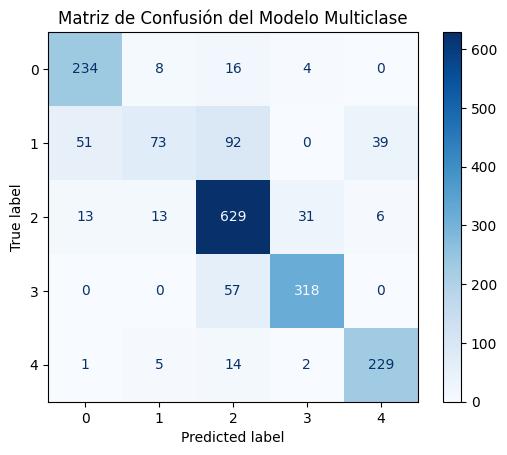

In [71]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión del Modelo Multiclase")
plt.show()

**Ejes del Gráfico:**

- Eje vertical: Representa las etiquetas verdaderas (valores reales de las clases).

- Eje horizontal: Representa las etiquetas predichas por el modelo (valores estimados por el clasificador).

**Interpretación de los Valores:**

Diagonal principal: Indica las instancias correctamente clasificadas. Por ejemplo:

- Clase 0: 234 instancias fueron clasificadas correctamente.

- Clase 2: 629 instancias, el mejor desempeño entre todas las clases.

Fuera de la diagonal: Muestra los errores de clasificación. Por ejemplo:

- Clase 1: 51 instancias se clasificaron erróneamente como clase 0.

- Clase 3: 57 instancias se clasificaron erróneamente como clase 2.

**Tendencias y Observaciones:**

- Clase dominante (2): Esta clase tiene el mejor desempeño, con 629 instancias correctamente clasificadas y solo unos pocos errores (13 instancias clasificadas como 1 y 31 como 3). Este buen rendimiento refleja que el modelo identifica eficazmente esta clase, posiblemente debido a su mayor cantidad de datos en el conjunto de entrenamiento.

- Clase 3: Aunque logra 318 clasificaciones correctas, presenta confusión significativa con la clase 2, ya que 57 instancias se clasificaron erróneamente como clase 2.
Esto sugiere cierta similitud en las características que definen estas dos clases.

- Clase 1: Esta clase muestra la mayor dispersión, con 51 instancias clasificadas como 0 y 92 como 2.
El modelo tiene dificultades para diferenciar la clase 1 de las clases cercanas, lo que podría ser un reflejo de una menor cantidad de datos o características menos representativas para esta clase.

- Clases con errores mínimos:

  - Clase 0: 234 de 262 instancias fueron clasificadas correctamente, con pocos errores dispersos.

  - Clase 4: También presenta buen desempeño, con la mayoría de las instancias clasificadas correctamente.


  En conclusión, el modelo muestra un buen rendimiento en clases con más datos, como la clase 2, lo cual es típico en problemas de clasificación multiclase con desbalance de clases. Sin embargo, las clases 1 y 3 presentan desafíos importantes, con errores significativos al confundirse con otras clases cercanas. La confusión entre clases, por ejemplo, clase 3 con clase 2, sugiere similitudes en las características compartidas o una insuficiencia en la separación entre estas categorías.


## Curvas ROC por clase

Las curvas ROC permiten verificar si el modelo tiene un desempeño consistente entre clases y ayudan a justificar ajustes en los umbrales de decisión, especialmente para fases difíciles de predecir.

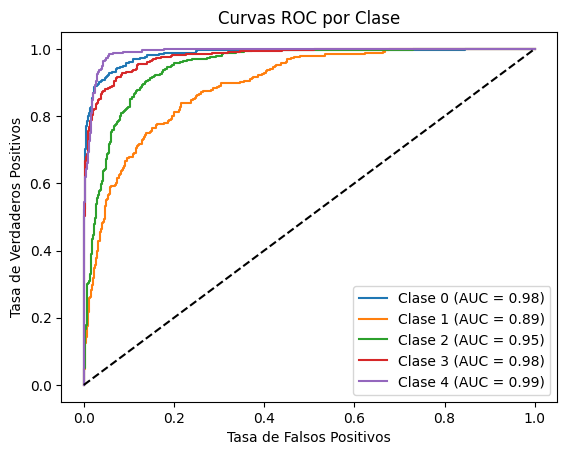

In [72]:
from sklearn.metrics import auc
for i in range(params['num_class']):
    fpr, tpr, _ = roc_curve(y_test == i, y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por Clase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

**Ejes del Gráfico:**

- Eje horizontal (Tasa de Falsos Positivos - FPR): Indica el porcentaje de negativos clasificados como positivos.

- Eje vertical (Tasa de Verdaderos Positivos - TPR): Representa el porcentaje de positivos correctamente clasificados.

- Diagonal (línea punteada): Representa un clasificador aleatorio con AUC = 0.5. Cuanto más alejada esté la curva de esta línea, mejor será el desempeño del modelo.


**Resultados por Clase**:

Clase 0 (AUC = 0.98):
   - Excelente desempeño.
   - La curva se encuentra muy cerca del extremo superior izquierdo, reflejando alta sensibilidad (recall) y especificidad.

Clase 1 (AUC = 0.89):
   - Es la clase con menor AUC, lo que confirma que el modelo tiene más dificultades para diferenciar esta clase de las demás.
   - Este desempeño, aunque aceptable, indica la necesidad de posibles ajustes o estrategias adicionales.

Clase 2 (AUC = 0.95):
   - Muy buen rendimiento.
   - La curva muestra una clara separación entre esta clase y las demás.

Clase 3 (AUC = 0.98):
   - Desempeño excelente, comparable al de la clase 0.
   - El modelo logra diferenciar esta clase de manera precisa en la mayoría de los casos.

Clase 4 (AUC = 0.99):
   - Sobresaliente. Esta clase tiene el mejor desempeño, con una curva casi perfecta.
   - El modelo distingue esta clase de las demás con gran precisión.

**Tendencias y Observaciones**:

Clases con excelente desempeño: Las clases 0, 3 y 4 tienen AUC superiores a 0.98, lo que indica que el modelo puede distinguirlas de manera muy precisa.
  
Clase problemática: La clase 1 presenta la menor AUC (0.89). Aunque el desempeño sigue siendo aceptable, esta clase muestra mayores desafíos para el modelo, lo que también se observó en la matriz de confusión.


Por tanto, el modelo tiene un desempeño sobresaliente, con AUC superiores a 0.95 en cuatro de las cinco clases, lo que refleja una sólida capacidad para distinguir entre las diferentes clases en la mayoría de los casos. Sin embargo, la clase 1 requiere atención especial, ya que la AUC de 0.89 indica que el modelo tiene dificultades para separarla correctamente de otras clases. Esto podría abordarse mediante técnicas como la reponderación de clases, el ajuste de umbrales o la incorporación de características adicionales. En resumen, este análisis reafirma la robustez general del modelo, pero reafirma la necesidad de enfoques específicos para fortalecer su desempeño en la clase 1 y garantizar una mayor consistencia en las predicciones.




---

## Conclusión Final

Este proyecto ha desarrollado un modelo  eficaz para la clasificación automática de las fases del sueño, alcanzando un AUC promedio de 0.9583 y una precisión del 81% en el conjunto de test. El modelo completo, que utiliza todas las variables disponibles, demostró un desempeño superior en comparación con versiones reducidas, destacándose en la clasificación de las clases 0, 3, y 4. Sin embargo, se identificaron desafíos en la clase 1, que mostró menor sensibilidad y precisión. Las variables EEG, EMG y EOG jugaron un papel fundamental en el rendimiento del modelo, y las técnicas de interpretabilidad, como SHAP, permitieron justificar los resultados.

En general, este modelo representa un avance significativo en la automatización del análisis del sueño, ofreciendo una herramienta precisa y clínicamente interpretable. Aunque los resultados son prometedores, se recomienda realizar ajustes adicionales para mejorar el rendimiento en clases complejas y validar el modelo en datos externos para garantizar su aplicabilidad en diversos contextos clínicos.